<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-libs" data-toc-modified-id="import-libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import libs</a></span></li><li><span><a href="#set-parameters" data-toc-modified-id="set-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>set parameters</a></span></li><li><span><a href="#Parse-Lammps-dump-file" data-toc-modified-id="Parse-Lammps-dump-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parse Lammps dump file</a></span></li><li><span><a href="#Energy" data-toc-modified-id="Energy-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Energy</a></span><ul class="toc-item"><li><span><a href="#main()" data-toc-modified-id="main()-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>main()</a></span></li></ul></li><li><span><a href="#Train-NN" data-toc-modified-id="Train-NN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train NN</a></span></li></ul></div>

# import libs

In [9]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#
import os
import sys
sys.path.append(confParser['input files']['lib_path'])
from dscribe.descriptors import SOAP, ACSF
import ase
import ase.io
import ase.build
from ase.io import lammpsdata
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot as plt
if not eval(confParser['flags']['RemoteMachine']):
    plt.rc('text', usetex=True)
import sklearn
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.stats import gaussian_kde


#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)


conf. file sections: ['flags', 'input files', 'EnergyBarrier', 'neural net']


<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

# Parse Lammps dump file

In [10]:
class ParseConfiguration:
    '''
    Parse k-art configuration file
    '''
    
    def __init__(self,confParser,verbose=False):

        #--- fetch parameters defect_file
        self.datFile = '%s/%s'%(confParser['input files']['input_path'],confParser['input files']['diffusion_file'])
        self.lib_path = confParser['input files']['lib_path']
        
        self.verbose = verbose

    def Parse(self,fp,outpt):
        #--- parse dump: call ovito
        t0=time.time()
        outpt_headers = 'dumpFile/calcResults.txt'
        !ovitos $self.lib_path/OvitosCna.py $fp $outpt 1 7 $outpt_headers
        if self.verbose:
            print('output dump file=%s s'%(time.time()-t0))

        #--- parse dump files
        if self.verbose:
            print('parsing %s'%(outpt))
        t0=time.time()
        self.lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
        self.lmpData.GetCords( ncount = sys.maxsize)
        if self.verbose:
            print('elapsed time=%s s'%(time.time()-t0))
            print('time steps:',self.lmpData.coord_atoms_broken.keys())
            display(self.lmpData.coord_atoms_broken[0].head())

        #--- add timescales
        self.lmpData.times = np.loadtxt(self.datFile)[:,0]

        #--- parse headers
        data = np.loadtxt(outpt_headers)
        if data.shape[1] == 4:
            self.lmpData.headers = pd.DataFrame(data,columns=["Barrier", "Energy", "Step", "Time"])
        elif data.shape[1] == 2:
            self.lmpData.headers = pd.DataFrame(data,columns=["Step", "Time"])


    def WignerSeitz(self,fp,reference_file):
        '''
        perform Wigner-Seitz algorithm
        '''
        outpt = 'dumpFile/dump_defect.xyz'

        #--- parse dump: call ovito
        if self.verbose:
            print('input=',fp)
        t0=time.time()
        !ovitos $self.lib_path/OvitosCna.py $fp $outpt 1 11 $reference_file
        if self.verbose:
            print('output dump file=%s s'%(time.time()-t0))

        #--- parse dump files
        if self.verbose:
            print('parsing %s'%(outpt))
        t0=time.time()
        self.lmpData_defect = lp.ReadDumpFile( '%s'%(outpt) ) 
        self.lmpData_defect.GetCords( ncount = sys.maxsize)
        if self.verbose:
            print('elapsed time=%s s'%(time.time()-t0))

        if self.verbose:
            print('time steps:',self.lmpData_defect.coord_atoms_broken.keys())
            display(self.lmpData_defect.coord_atoms_broken[0].head())

        #--- add timescales
        self.lmpData_defect.times = np.loadtxt(self.datFile)[:,0]


    def Print(self,fout):
        '''
        dump vacant sites
        '''
        
        times = list( self.lmpData_defect.coord_atoms_broken.keys() )
        times.sort()

        #--- print dump
        !rm $fout
        for ii in times:
            filtr = self.lmpData_defect.coord_atoms_broken[ii].Occupancy == 0.0
            df = self.lmpData_defect.coord_atoms_broken[ii][filtr]
            assert df.shape[0] == 1
            df.id=1;df.type=1
        #    print(df)
            atom_current = lp.Atoms(**df)
            box  = lp.Box( BoxBounds = self.lmpData_defect.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
            with open(fout,'a') as fp:
                lp.WriteDumpFile(atom_current, box).Write(fp, itime = ii,
                     attrs=['id', 'type','x', 'y', 'z'],
        #                 fmt='%i %i %15.14e %15.14e %15.14e',
                                                     )
                
    def Displacement(self, fp, fout):
        '''
        Return total displacements 
        '''
        !rm $fout

        #--- fetch parameters
        fileCurr = fileRef = fp

        #--- call ovito
        t0 = time.time()
        os.system('ovitos %s/OvitosCna.py %s %s 1 8 %s'%(self.lib_path,fileCurr,fout,fileRef))
        if self.verbose:
            print('output disp:%s s'%(time.time()-t0))

        #--- parse disp files
        if self.verbose:
            print('parsing %s'%fout)
        t0 = time.time()
        self.lmpDisp = lp.ReadDumpFile( fout )
        self.lmpDisp.GetCords( ncount = sys.maxsize )
        if self.verbose:
            print('elapsed time %s s'%(time.time()-t0))
            display(self.lmpDisp.coord_atoms_broken[0].head())



In [11]:
def main():
    !rm -r dumpFile; mkdir dumpFile
    
    #--- parse allconf
    pc = ParseConfiguration(confParser,verbose=True)
    #
    pc.Parse('%s/%s'%(confParser['input files']['input_path'],confParser['input files']['dump_file']),
            'dumpFile/dump.xyz',
            )
    
#     #--- ws analysis
#     pc.WignerSeitz('%s/%s'%(confParser['input files']['input_path'],confParser['input files']['dump_file']),
#                    '%s/%s'%(confParser['input files']['input_path'],confParser['input files']['pure_crystal'])
#               )
#     #--- output vacant sites
#     pc.Print('dumpFile/dump_vacant.xyz')
    
    
#     #--- vacancy disp
#     pc.Displacement('dumpFile/dump_vacant.xyz',
#                     'disp/disp_vacant.xyz')
#     pc.lmpDisp_defect = pc.lmpDisp
    
    #--- total displacements
    !mkdir disp
    pc.Displacement('dumpFile/dump.xyz',
                    'disp/disp.xyz')

    #--- parse allconf_defect
#     pc_defect = ParseConfiguration(confParser,verbose=True)
#     pc_defect.Parse('%s/%s'%(confParser['input files']['input_path'],confParser['input files']['defect_file']))

    return pc

data_xyz = main()


output dump file=1.8950018882751465 s
parsing dumpFile/dump.xyz
elapsed time=0.09272885322570801 s
time steps: dict_keys([0, 1, 2])


,id,type,x,y,z
0,1,1,19.823929,18.054071,19.823696
1,2,1,0.353771,16.284138,2.124210
2,3,1,18.054001,16.284338,5.664271
3,4,1,3.893790,12.744229,16.283861
4,5,1,9.204130,5.663917,0.354000


mkdir: disp: File exists
output disp:1.585303783416748 s
parsing disp/disp.xyz
elapsed time 0.0868220329284668 s


,id,type,x,y,z,DisplacementX,DisplacementY,DisplacementZ
0,1,1,19.823929,18.054071,19.823696,0.0,0.0,0.0
1,2,1,0.353771,16.284138,2.124210,0.0,0.0,0.0
2,3,1,18.054001,16.284338,5.664271,0.0,0.0,0.0
3,4,1,3.893790,12.744229,16.283861,0.0,0.0,0.0
4,5,1,9.204130,5.663917,0.354000,0.0,0.0,0.0


# Energy

In [12]:
class LocalDensity:
    
    def __init__(self,confParser,fp,rcut,scale,verbose=False):
        '''
        Return local density using a gaussian kernel
        '''
        
        self.lib_path = confParser['input files']['lib_path']
        self.input = fp
        self.verbose = verbose
        self.rcut = rcut
        self.scale = scale

    def GetNeighborList(self):
        '''
        return neighbor list
        '''

        #--- list of atoms
        self.lmpData = lp.ReadDumpFile(self.input)
        self.lmpData.GetCords()
        natom = len(self.lmpData.coord_atoms_broken[0])
        atoms = ' '.join(map(str,range(natom)))

        outpt = 'neigh_list.xyz'
        #--- load every atom
        t0 = time.time()
        !ovitos $self.lib_path/OvitosCna.py $self.input $outpt 1 6 $self.rcut $atoms

        #--- parse
        lmpNeigh = lp.ReadDumpFile( 'neigh_list.xyz' )
        lmpNeigh.GetCords( ncount = sys.maxsize)
        self.neighList = lmpNeigh.coord_atoms_broken[0]
        if self.verbose:
            print('Build neighbor list: elapsed time=%s s'%(time.time()-t0))
            display(self.neighList)

        #--- clean
        !rm neigh_list.xyz
        
    def Grid(self,sigma):
        '''
        retuubric gid
        '''
        #--- grid
        #--- assert n is odd
        xlin = np.arange(-self.rcut,self.rcut,sigma)
        ylin = np.arange(-self.rcut,self.rcut,sigma)
        zlin = np.arange(-self.rcut,self.rcut,sigma)
        if self.verbose:
            print('xdim=',len(xlin))
            print('ydim=',len(ylin))
            print('zdim=',len(zlin))
        self.xv, self.yv, self.zv = np.meshgrid(xlin,ylin,zlin)
#         r_flat = list(zip(xv.flatten(), yv.flatten(), zv.flatten()))
        self.positions = np.c_[self.xv.flatten(),self.yv.flatten(),self.zv.flatten()].T

    def ScatterPoints(self,atom_ids):
        '''
        return kde
        '''
        self.groups = self.neighList.groupby(by='id').groups
        atom_ids_groups = list(self.groups.keys())
        
        t0 = time.time()
#        atom_ids = self.lmpData.coord_atoms_broken[0]['id']
        
        assert LocalDensity.ListEmpty(atom_ids,atom_ids_groups), 'increase cutoff!'
        
        rho = np.concatenate([list(map(lambda x:self.GetRho(x),atom_ids))])

        if self.verbose:
            print('kde: elapsed time=%s s'%(time.time()-t0))
            print('rho.shape:(%s,%s)'%(tuple(rho.shape)))

        return rho

    def GetRho(self,atom_id):
        '''
        kde corresponding to atom_id
        '''
        self.values = np.c_[self.neighList.iloc[self.groups[atom_id]]['DX DY DZ'.split()]].T
        return LocalDensity.GaussianKernel(self.positions,self.values,self.scale)
    

    @staticmethod
    def GaussianKernel(positions,values,scale):
        kernel = gaussian_kde(values,bw_method=scale)
#         print('scale=',kernel.factor)
        return kernel(positions)
    
    @staticmethod
    def ListEmpty(l1,l2):
        slist = list(set(l1) - set(l2))
        return len(slist) == 0

    def Plot(self,data,**kwargs):
        #form a kernel density estimate on the data:
        xmin = self.positions[0].min()
        xmax = self.positions[0].max()
        ymin = self.positions[1].min()
        ymax = self.positions[1].max()

        #--- reshape
        rho = data.reshape(self.xv.shape)


        # plot the results: z=0
        nz = int(rho.shape[2]/2)
        rho_slice = rho[:,:,nz]


        fig, ax = plt.subplots()
        ax.imshow(rho_slice, cmap=plt.cm.bwr,
                  extent=[xmin, xmax, ymin, ymax],
                 origin='lower',
                 )

        
        filtr = np.abs(self.values[2]) < 1e-6
#         print(np.c_[self.values[0][filtr], self.values[1][filtr]])
#         pdb.set_trace()
        ax.plot(self.values[0][filtr], self.values[1][filtr], 'k.', markersize=8)
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        
        ax.set_xlabel(r'$x$',fontsize=18)
        ax.set_ylabel(r'$y$',fontsize=18)
        
        ax.tick_params(labelsize=18,which='both',axis='both', top=True, right=True)

        
        plt.savefig(kwargs['title'],dpi=300 if not 'dpi' in kwargs else kwargs['dpi'],bbox_inches='tight',
                    pad_inches=0.0)
        plt.show()

    def Print2D(self,fp,data):
        xmin = self.positions[0].min()
        xmax = self.positions[0].max()
        ymin = self.positions[1].min()
        ymax = self.positions[1].max()

        #--- reshape
        rho = data.reshape(self.xv.shape)


        # plot the results: z=0
        nz = int(rho.shape[2]/2)
        rho_slice = rho[:,:,nz]
        
        np.save(fp,rho_slice)

Build neighbor list: elapsed time=3.0277860164642334 s


,id,type,J,Jtype,DIST,DX,DY,DZ,PBC_SHIFT_X,PBC_SHIFT_Y,PBC_SHIFT_Z
0,1,1,502.0,1.0,2.503296,-1.769928,-0.000023,1.770267,0.0,0.0,0.0
1,1,1,691.0,1.0,2.503056,-1.769928,1.769928,0.000553,0.0,0.0,0.0
2,1,1,1348.0,1.0,2.502764,-0.000206,1.769928,-1.769514,0.0,0.0,0.0
3,1,1,804.0,1.0,2.502919,-1.769928,-1.769733,0.000032,0.0,0.0,0.0
4,1,1,710.0,1.0,2.502764,-1.769928,0.000206,-1.769514,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
16435,1371,1,402.0,1.0,2.503425,1.770189,-1.770189,0.000057,0.0,0.0,0.0
16436,1371,1,585.0,1.0,2.503169,1.770072,-0.000028,-1.769943,0.0,0.0,0.0
16437,1371,1,1055.0,1.0,2.503169,0.000028,-1.770073,-1.769943,0.0,0.0,0.0
16438,1371,1,1100.0,1.0,2.503281,-1.770129,-1.770044,-0.000004,0.0,0.0,0.0


xdim= 55
ydim= 55
zdim= 55
kde: elapsed time=0.08246111869812012 s
rho.shape:(1,166375)


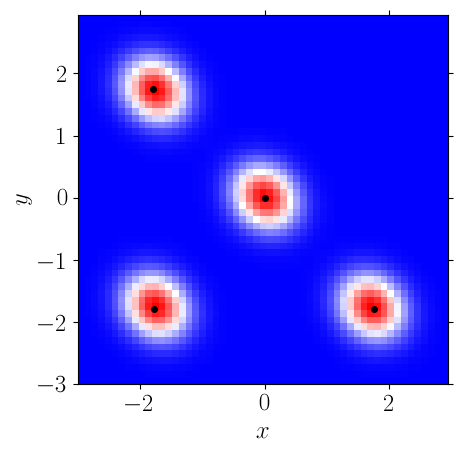

kde: elapsed time=0.057543039321899414 s
rho.shape:(1,166375)


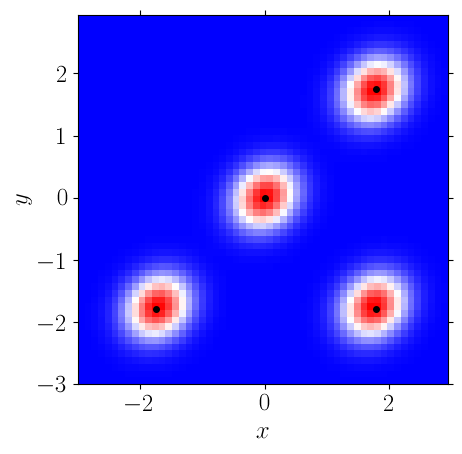

kde: elapsed time=0.0751807689666748 s
rho.shape:(1,166375)


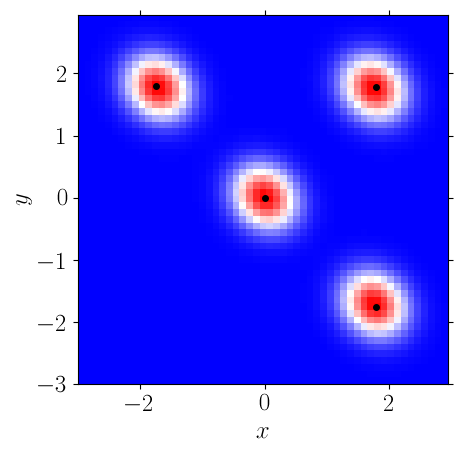

kde: elapsed time=0.13572406768798828 s
rho.shape:(1,166375)


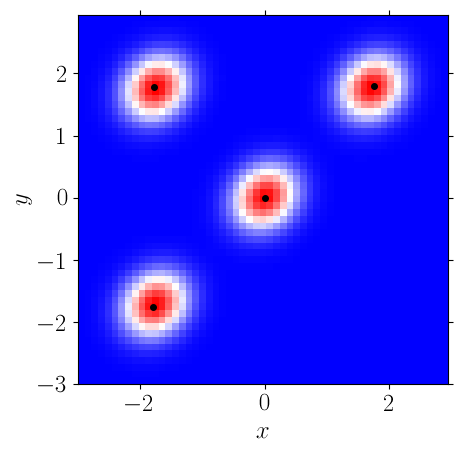

In [13]:
# ld = LocalDensity( confParser, 'lammps.xyz', 
#                   eval(confParser['EnergyBarrier']['r_cut']), 
#                   scale = eval(confParser['EnergyBarrier']['scale']),
#                    verbose=True
#                  )
# ld.GetNeighborList()
# #--- grid
# ld.Grid(eval(confParser['EnergyBarrier']['dr']))
# #--- add zero
# atom_ids=[130,608,795, 1209]
# cols=list(ld.neighList.keys())
# for atom_id in atom_ids:
#     new_entry=np.c_[np.array([atom_id,1,atom_id,1,0,0,0,0,0,0,0])].T
#     data=np.concatenate([np.c_[ld.neighList],new_entry],axis=0)
#     ld.neighList = pd.DataFrame(np.c_[data],columns=cols)
# for atom_id, indx in zip(atom_ids,range(4)):
#     descriptors = ld.ScatterPoints([atom_id])
#     ld.Plot(descriptors,title='png/descriptor%s.png'%indx)
#     ld.Print2D('png/descriptor%s'%indx,descriptors)

In [14]:
# data.perAtomData.iloc[:14]

In [97]:
# plt.rc('text', usetex=True)


In [17]:
class EnergyBarrier:
    '''
    return energy barriers corresponding to diffusional hopping
    '''
    def __init__(self,
                 events_directory,evlist_directory,
                 lmpData,
                 lmpDisp,
                 nconf = sys.maxsize,
                 verbose=False,
                 **kwargs
                ):
        
        self.events_dir = events_directory
        self.evlist_dir = evlist_directory
        self.lmpData    = lmpData.coord_atoms_broken[0]
        self.lmpDisp    = lmpDisp.coord_atoms_broken[2]
        self.box        = lp.Box(BoxBounds=lmpData.BoxBounds[0],AddMissing=np.array([0,0,0]))

        #--- soap parameters
        for key in kwargs:
            setattr(self, key, kwargs[ key ] )

        #
        self.nconf = np.min(np.array([nconf,sys.maxsize]))
        self.verbose = verbose
        
    def Parse(self):
        '''
        parse event files
        '''
        self.events_id_energy = self.ParseEvents_dir()
        self.catalog          = self.ParseEvList_dir()
        self.diffusionPaths   = self.ParseDiffusionPath()
        
        
    def ParseEvents_dir(self):
        '''
        return energy barriers associated with hopping events
        '''
        if self.verbose:
            print('parsing events ...')
        files = os.listdir(self.events_dir)
        d=[]
        count = 0
        for sfile in files:
            if not '.xyz' in sfile: #--- skip .xyz files 
                try:
                    filee=open('%s/%s'%(self.events_dir,sfile)) #--- open file
                    xstrs = filee.readlines()
                    event_id = int(xstrs[0].split()[-1]) #--- event id
                    barrier = float(xstrs[2].split()[-1]) #--- energy
                    ncluster =  int(xstrs[15].split()[-1])                 
                    shape_cluster_atoms =  int(xstrs[16].split()[-1])
                    atom_id = int(xstrs[17+ncluster].split()[0])
                    if self.verbose:
                        print('file=%s atom_id=%s'%(sfile,atom_id))
                    d = np.c_[event_id,atom_id,barrier] if len(d) == 0 else\
                    np.concatenate([d,np.c_[event_id,atom_id,barrier]])
                    #
                    if count > self.nconf:
                        break
                    count += 1
                except:
#                    traceback.print_exc()
                    continue
            
        #--- extract types
        df       = self.lmpData
        atom_ids = d[:,1]
        types    = utl.FilterDataFrame(df, 
                    key='id', 
                    val=atom_ids
                   )['type']

        return pd.DataFrame(np.c_[types,d],columns=['atom_type','event_id','atom_id','barrier'])

    @staticmethod
    def ReadConfigurationFile(dumpFile, outpt, outpt_headers):
        '''
        return displacements
        '''
#        !rm outpt outpt_headers
        lib_path = confParser['input files']['lib_path']

        #--- parse dump: call ovito
        !ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers

        #--- parse dump files
        lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
        lmpData.GetCords( ncount = sys.maxsize)

        #--- disp
        fileCurr = fileRef = outpt #'dumpFile/dump.xyz'
        outpt = 'disp.xyz'
#        !rm $outpt

        #--- call ovito
        os.system('ovitos %s/OvitosCna.py %s %s 1 8 %s'%(lib_path,fileCurr,outpt,fileRef))

        #--- parse disp files
        lmpDisp = lp.ReadDumpFile( outpt )
        lmpDisp.GetCords( ncount = sys.maxsize )
        return lmpDisp

    @staticmethod
    def GetEventid(filestr):
        '''
        extract event id from input string
        '''
        n = len(filestr)
        return int(filestr[5:n-4])
    
    def ParseDiffusionPath(self):
        '''
        return diffusion path corresponding to hopping events
        '''
        if self.verbose:
            print('parsing ParseDiffusionPath ...')
        disps = {}
        count = 0
        files = os.listdir(self.events_dir)
        self.events_id_energy
        for event_id in list(map(int,self.events_id_energy.event_id)):
#        for sfile in files:
#            if '.xyz' in sfile: #--- skip .xyz files 
#                try:
                    dumpFile = '%s/event%s.xyz'%(self.events_dir,event_id) #--- open file
                    #         outpt = 'dumpFile/dump.xyz'
#                    event_id = EnergyBarrier.GetEventid(sfile)
                    disps[event_id] = \
                    EnergyBarrier.ReadConfigurationFile(dumpFile, 'dump.xyz', 'calcResults.txt')
                    if self.verbose:
                        print('event_id=%s'%(event_id))
                    #
                    if count > self.nconf:
                        break
                    count += 1
#                 except:
#                     traceback.print_exc()
#                     continue
        return disps
    
    def ParseEvList_dir(self):
        files = os.listdir(self.evlist_dir)
        events={}
        for sfile in files:
            try:
                kmc_step = int(sfile.split('_')[-1])
        #        print(kmc_step)
                filee=open('%s/%s'%(self.evlist_dir,sfile)) #--- open file
                events[kmc_step] = pd.read_csv(filee,delim_whitespace=True).iloc[1:]#delimiter='')
            except:
                continue
        return events
        
    def SplitByType(self):
        '''
        return energies (parsed from catalogs) slipt by atom types
        '''
        kmc_steps = list(self.catalog.keys())
        kmc_steps.sort()


        #--- dict based on types
        df_concat = {}
        types = list(set(self.lmpData.type))
        for itype in types:
            df_concat[str(itype)] = {}

        for kmc_step in kmc_steps: #--- kmc loop
            df = self.catalog[kmc_step]
            sdict=df.groupby(by='#TypeId').groups #--- group by type
            for itype in sdict:
                indices = sdict[itype] #--- row index: atoms with  '#TypeId' == itype
                cond = len(df_concat[itype]) == 0 #--- empty key?
                df_concat[itype] = np.c_[df.loc[indices]] if cond else\
                np.concatenate([df_concat[itype],np.c_[df.loc[indices]]],axis=0)

        self.energyByType = {}
        for itype in df_concat:
             self.energyByType[ itype ] = pd.DataFrame(df_concat[itype],columns=list(df.keys()))        

    def SetDescriptors(self,**kwargs):
        
        positions = self.perAtomData['x y z'.split()]

        #--- convert to lammps data file
        atom = lp.Atoms(**self.perAtomData['id type x y z'.split()].to_dict(orient='series'))
        wd = lp.WriteDataFile(atom, self.box, {1:1,2:1,3:1}) #--- modify!!
        wd.Write('lammps.dat')
        wd = lp.WriteDumpFile(atom, self.box)
        wd.Write('lammps.xyz', itime=0)
        
        
        #--- load configuration
        atoms = ase.io.read("lammps.dat",format="lammps-data",style='atomic')

       #--- set atomic numbers for each species
        junk = SOAP(
            species=self.species,
            periodic=True,
            r_cut=self.r_cut,
                n_max=1,
                l_max=1,
        )
        types=atoms.get_atomic_numbers()
        numbers = list(map(lambda x:junk.index_to_atomic_number[x-1],atoms.get_atomic_numbers()))
        atoms.set_atomic_numbers(numbers)
        numbers = atoms.get_atomic_numbers()
        #assert soap.check_atomic_numbers(atoms.get_atomic_numbers())

        
        #--- Setting up the SOAP descriptor
        if 'soap' in kwargs and kwargs['soap']:
            soap = SOAP(
                species=self.species,
                periodic=True,
                r_cut=self.r_cut,
                n_max=self.n_max,
                l_max=self.l_max,
            )
           
            #--- center atom is the last entry
            self.descriptors = soap.create( atoms) #,centers=[atoms.get_number_of_atoms()-1])

            #--- descriptor dimension
            count = 0
            nspecies = len(self.species)
            for Z in range(nspecies):#atoms.get_atomic_numbers():
                for Zprime in range(nspecies): #atoms.get_atomic_numbers():
                    for l in range(self.l_max+1):
                        for n in range(self.n_max):
                            for nprime in range(self.n_max):
                                if nprime >= n and Zprime >= Z:
                                    count += 1
            assert count == self.descriptors[0].shape[0], 'count = %s, soap.shape=%s'%(count,self.descriptors[0].shape[0])

        #--- Setting up the parinello descriptor
        if 'acsf' in kwargs and kwargs['acsf']:
            dr = 0.01
            eta_inv = 0.1
            eta = 1/eta_inv
            zeta = 2
            lambdaa = 1 #-1
            Rs = np.arange(0,self.r_cut,dr)
            acsf = ACSF(
            species=self.species,
            r_cut=self.r_cut,
            g2_params= list(zip(np.ones(len(Rs))*eta,Rs)), #[[1, 1], [1, 2], [1, 3]],
#            g4_params=[[eta, zeta, lambdaa]],
            g4_params=[[eta, 1, 1], [eta, 2, 1], [eta, 1, -1], [eta, 2, -1]],
        )

            self.descriptors = acsf.create( atoms) #,centers=[atoms.get_number_of_atoms()-1])
            
        #--- g(r) as descriptors
        if 'gr' in kwargs and kwargs['gr']:
            ld = LocalDensity( self.confParser, 'lammps.xyz', self.r_cut, self.scale, verbose=self.verbose )
            ld.GetNeighborList()
            ld.Grid(self.dr)
            self.descriptors = ld.ScatterPoints(self.perAtomData.id)

    def DefectFreeCrystal(self):
        '''
        Return a crystalline structure
        '''
        # Lets create an FCC(111) surface
        a=2.5*2**0.5
        atoms = ase.build.fcc100(
            "Ni",
             (16,16,16),
            a=a,
    #        vacuum=10,
            periodic=True
        )

        atoms.pop(i=-1)
        
        lammpsdata.write_lammps_data('junk.dat', atoms )
        # Setting up the SOAP descriptor
        soap = SOAP(
            species=self.species,
            periodic=True,
            r_cut=self.r_cut,
            n_max=self.n_max,
            l_max=self.l_max,
        )

        #--- center atom is the last entry
        self.descriptors_defect_free = soap.create( atoms ) #,centers=[0])[0]

    def LabelDefects(self):
        '''
        Return a dataframe including per-atom energy and defect type 
        '''
        df = self.lmpData.copy()


        #--- modify dataframe
        df['energy_barrier']=np.inf
        df['defect_label']=0
        df['ux']=0.0
        df['uy']=0.0
        df['uz']=0.0

        #--- defective atoms: add relevant columns
        defective_atom_ids = np.c_[self.events_id_energy.atom_id].astype(int).flatten()
        df_filtrd = utl.FilterDataFrame(df,key='id',
                                        val=defective_atom_ids,
                                        )
        #--- energy
        energy = self.events_id_energy.barrier

        #--- disps
        event_ids = self.events_id_energy['event_id']
        config_no = 2 #--- relaxed conf
        loc_center = -1  #--- center
        keys = 'DisplacementX DisplacementY DisplacementZ'.split()
        disps=\
        np.concatenate(list(map(lambda x:
                                np.c_[self.diffusionPaths[x].coord_atoms_broken[config_no].iloc[loc_center][keys]].T,
                                event_ids)))

        #--- add columns
        keys = 'id type x y z'.split()
        df_mod = pd.DataFrame(np.c_[df_filtrd[keys],disps,energy,np.ones(len(df_filtrd))],
                              columns=keys+'ux uy uz energy_barrier defect_label'.split()
                             )

        #--- concatenate dataframes
        crystalline_atom_ids = np.array(set(df.id)-set(defective_atom_ids))
        df_negated = utl.FilterDataFrame(df,key='id',
                                        val=crystalline_atom_ids,
                                        )

        data_concat = np.concatenate([np.c_[df_mod],np.c_[df_negated]],axis=0) 
        self.perAtomData = pd.DataFrame(data_concat,
                              columns=list(df_mod.keys())
                             )
        
    def LabelDefectsUpdated(self):
        '''
        Return a dataframe including per-atom energy and defect type 
        '''
        
        df = self.lmpData.copy()


        #--- modify dataframe
        df['energy_barrier']=np.inf
        df['defect_label']=0
        df['ux']=0.0
        df['uy']=0.0
        df['uz']=0.0

        #--- defective atoms: add relevant columns
        kmc_step = 1
        defective_atom_ids = np.c_[self.catalog[ kmc_step ][ 'AtomId' ]].astype(int).flatten()
#        defective_atom_ids = np.c_[self.events_id_energy.atom_id].astype(int).flatten()
        df_filtrd = utl.FilterDataFrame(df,key='id',
                                        val=defective_atom_ids,
                                        )
        #--- energy
        energy = self.catalog[ kmc_step ][ 'barrier' ]

        #--- disps
        event_ids = np.c_[self.catalog[ kmc_step ][ 'eventId' ]].astype(int).flatten()
        config_no = 2 #--- relaxed conf
        center_atom_indx, center_atom_id = self.GetCenterAtom()  #--- center
        assert center_atom_id in defective_atom_ids
#         disps=\
#         np.concatenate(list(map(lambda x:
#                                 np.c_[self.diffusionPaths[x].coord_atoms_broken[config_no].iloc[loc_center][keys]].T,
#                                 event_ids)))
        disps = np.zeros(3*len(event_ids)).reshape((len(event_ids),3))
        #--- add columns
        keys = 'id type x y z'.split()
        df_mod = pd.DataFrame(np.c_[df_filtrd[keys],disps,energy,np.ones(len(df_filtrd))],
                              columns=keys+'ux uy uz energy_barrier defect_label'.split()
                             )
        #--- only one diffusion path per mc sweep
        new_indx = df_mod[df_mod.id == center_atom_id].index[0] #--- new indx for center atom
        keys = 'DisplacementX DisplacementY DisplacementZ'.split()
#        pdb.set_trace()
        df_mod.iloc[new_indx]['ux uy uz'.split()] = list(self.lmpDisp.iloc[center_atom_indx][keys]) #--- assign disp

        #--- concatenate dataframes
        crystalline_atom_ids = np.array(set(df.id)-set(defective_atom_ids))
        df_negated = utl.FilterDataFrame(df,key='id',
                                        val=crystalline_atom_ids,
                                        )

        keys = list(df_mod.keys())
        data_concat = np.concatenate([np.c_[df_mod[keys]],np.c_[df_negated[keys]]],axis=0) 
        self.perAtomData = pd.DataFrame(data_concat,
                              columns=keys
                             )
#        pdb.set_trace()

        
    def GetCenterAtom(self):
        df = self.lmpDisp
        disp_magnitude = df.DisplacementX**2+df.DisplacementY**2+df.DisplacementZ**2
        center_atom_indx = disp_magnitude.sort_values(ascending=False).index[0]
        return center_atom_indx, int(df.iloc[ center_atom_indx ].id)
    
    def PrintPerAtomData(self,fout):
        with open(fout,'w') as fp: 
            np.savetxt(fp, np.c_[self.perAtomData].astype(float), header=' '.join(self.perAtomData.keys()))
            
    def PrintDescriptors(self,fout):
#        with open(fout,'w') as fp: 
        np.save(fout, np.c_[self.descriptors])

## main()

In [18]:
def main():
    if not eval(confParser['EnergyBarrier']['EnergyBarrier']):
        return
    
    eb = EnergyBarrier('%s/EVENTS_DIR'%confParser['input files']['input_path'],
                       '%s/EVLIST_DIR'%confParser['input files']['input_path'],
                       data_xyz.lmpData,
                       data_xyz.lmpDisp,
                       verbose = True,
                       nconf = 2, #--- only two events
                       confParser = confParser,
                       species = ['Ni'], #'Ni Co Cr'.split()
                       r_cut = eval(confParser['EnergyBarrier']['r_cut']),
                       dr = eval(confParser['EnergyBarrier']['dr']),
                       scale = eval(confParser['EnergyBarrier']['scale']),
                       n_max = 8,
                       l_max = 6,

                      )
    

    eb.Parse()
    #eb.events_id_energy extract from Events_dir
    #eb.energyByType extract from catalogs
    
    eb.LabelDefectsUpdated()
    
    #--- setup descriptors
    eb.SetDescriptors(
                      #soap = False,
                      #acsf = True,   
                      gr = True,
                     )
    
    
    #--- output
    eb.PrintPerAtomData('perAtomData.txt')
    eb.PrintDescriptors('descriptors')
    #--- 
#    eb.DefectFreeCrystal()    

    return eb
data = main()

parsing events ...
file=event697406 atom_id=970
file=event697407 atom_id=936
parsing ParseDiffusionPath ...
event_id=697406
event_id=697407
Build neighbor list: elapsed time=2.9495999813079834 s


,id,type,J,Jtype,DIST,DX,DY,DZ,PBC_SHIFT_X,PBC_SHIFT_Y,PBC_SHIFT_Z
0,1,1,502.0,1.0,2.503296,-1.769928,-0.000023,1.770267,0.0,0.0,0.0
1,1,1,691.0,1.0,2.503056,-1.769928,1.769928,0.000553,0.0,0.0,0.0
2,1,1,1348.0,1.0,2.502764,-0.000206,1.769928,-1.769514,0.0,0.0,0.0
3,1,1,804.0,1.0,2.502919,-1.769928,-1.769733,0.000032,0.0,0.0,0.0
4,1,1,710.0,1.0,2.502764,-1.769928,0.000206,-1.769514,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
16435,1371,1,402.0,1.0,2.503425,1.770189,-1.770189,0.000057,0.0,0.0,0.0
16436,1371,1,585.0,1.0,2.503169,1.770072,-0.000028,-1.769943,0.0,0.0,0.0
16437,1371,1,1055.0,1.0,2.503169,0.000028,-1.770073,-1.769943,0.0,0.0,0.0
16438,1371,1,1100.0,1.0,2.503281,-1.770129,-1.770044,-0.000004,0.0,0.0,0.0


xdim= 29
ydim= 29
zdim= 29
kde: elapsed time=14.06475305557251 s
rho.shape:(1371,24389)


In [8]:
# ld = LocalDensity( confParser, 'lammps.xyz', 3.0, 
#                  verbose=True,
#                  )
# ld.GetNeighborList()
# ld.Grid(0.3)
# rho = ld.ScatterPoints([1,2,3])
# ld.Plot(rho[0])


In [9]:


# #--- compute density
# def DensityKernel(df,rbar,sigma):
#         sigma2=sigma*sigma
#         rho=df.apply(lambda x: np.exp(-0.5*(np.sum((x['DX DY DZ'.split()]-rbar)**2)/sigma2)),axis=1) #--- Eq 5 in Ma et al. Materials Today 40 (2020)
#         #---
#         tmp=pd.DataFrame(np.c_[df.id,rho],columns=['id','rho'])
#         tmp_sum=tmp.groupby(by='id').rho.agg(np.sum)
#         return np.array(tmp_sum)

# #structFuncRad = np.array(list(map(lambda x:DensityKernel(neighList,x,sigma),r_flat))).T #--- attribute matrix



# #--- 2nd method kde


In [ ]:
# ax = utl.PltErr(None,None,Plot=False)

# for key in [9]:#rho:
#     xx=rho[key]
#     utl.PltErr(range(xx.shape[0]),xx,
#               attrs={'fmt':'-'},#,'color':'C0'},
# #               xscale='log',
# #               yscale='log',
#                ax=ax,
#                Plot=False,
#               )

